# Modelo de recomendação de Filmes
Este caderno contém a criação do modelo usado para recomendar filmes que estão ou vão entrar em cartaz no cinema.
Dados utilizados:https://grouplens.org/datasets/movielens/

#### Solução:
     A solução encontrada pela equipe consiste na utilização de um chatbot com a principal funcionalidade de compras de ingresso para o cinema. Além disso, o chatbot contará com uma ferramenta de recomendação de filmes que estão em cartaz ou que chegarão em breve. 
        Esse notebook contém a aplicação de um modelo de Machine Learning utilizando um algorítmo de clusterização (KMeans) para identificar grupos que possam ter gostos similares para filmes. A partir desse modelo, foi feito um algorítmo para encontrar filmes que outros usuários do mesmo grupo (cluster) também gostaram. 
        
        Essa implementação é a POC do Status 2.

#### Perguntas levantadas para construção da solução
    1. Como fazer com que estes dados representem o gosto do usuário?
    2. Como gerar uma forma de classificar os clientes pelos seus padrões de consumo?
    3. A partir desse padrão, como recomendar um filme que ele goste?
    4. Como recomendar filmes que estão e vão entrar em cartaz para clientes que tem mais chance de gostar?


In [213]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.figure_factory as ff
import random
import seaborn as sns
from plotly.offline import iplot
from scipy import stats
from sklearn.cluster import KMeans,MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, MinMaxScaler

#### Como fazer com que estes dados representem o gosto do usuário?
        Cada linha do dataset* contém uma review feita pelo usuário. A partir dessa linha foi gerada outra coluna contendo a média de nota o usuário deu para todos os filmes, ou seja, cada usuário tem uma média de notas diferente. A outra coluna gerada foi a adg_rating que representa a diferença de nota entre a média de notas que o usuário deu e a nota que ele deu para o filme que ele fez a review.   
        Utilizando apenas as colunas userId, movieId e adg_rating, foi criado um novo dataset que contem o userId como linhas, movieId como colunas e o valor sendo o adg_rating. A razão disso seria porque os valores negativos representariam que o usuário não gostou do filme e os positivos que o usuário gostou. Para os valors NaN, foi colocado a média de adg_rating do movieId.
    
        *Num ambiente com mais recursos o modelo deveria utilizar todos os dados, porém, como essa base de dados possui um tamanho muito grande, foi utilizado apenas os primeios 250.000 valores.

In [168]:
movies = pd.read_csv("movies.csv",encoding="Latin1")
Ratings = pd.read_csv("ratings.csv")
Mean = Ratings.groupby(by="userId",as_index=False)['rating'].mean()
Rating_avg = pd.merge(Ratings,Mean,on='userId')
Rating_avg['adg_rating']=Rating_avg['rating_x']-Rating_avg['rating_y']
Rating_avg.head()

,userId,movieId,rating_x,timestamp,rating_y,adg_rating
0,1,296,5.0,1147880044,3.814286,1.185714
1,1,306,3.5,1147868817,3.814286,-0.314286
2,1,307,5.0,1147868828,3.814286,1.185714
3,1,665,5.0,1147878820,3.814286,1.185714
4,1,899,3.5,1147868510,3.814286,-0.314286
...,...,...,...,...,...,...
351,3,3879,3.5,1439474297,3.697409,-0.197409
352,3,3948,3.0,1566089739,3.697409,-0.697409
353,3,3968,3.0,1566090300,3.697409,-0.697409
354,3,3969,4.0,1439473087,3.697409,0.302591


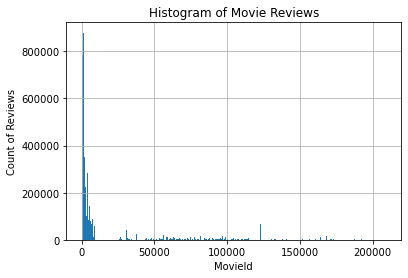

In [106]:
plt.hist(Rating_avg['movieId'].values, bins=len(sample['movieId'].value_counts()))

plt.xlabel('MovieId')
plt.ylabel('Count of Reviews')
plt.title('Histogram of Movie Reviews')
plt.grid(True)
plt.show()

In [163]:
df = pd.DataFrame([])
df['count'] = Rating_avg['movieId'].value_counts()
# Eliminando valores que tem menos que 100 reviews
df = df[df['count'] > 100]

df['movieId'] = df.index
df.describe()

,count,movieId
count,10291.000000,10291.000000
mean,2374.879021,38438.544942
std,5533.345188,51097.458313
min,101.000000,1.000000
25%,215.000000,3087.500000
50%,550.000000,6797.000000
75%,1843.500000,65339.500000
max,81491.000000,205383.000000


In [108]:
mean = df['count'].mean()
std  = df['count'].std()
df_new = df[df['count'] >= mean + std]
df_new.describe()

,count,movieId
count,777.000000,777.000000
mean,17447.018018,14805.168597
std,11436.467419,29236.192652
min,7917.000000,1.000000
25%,10077.000000,1036.000000
50%,13401.000000,2273.000000
75%,20407.000000,5991.000000
max,81491.000000,164179.000000


In [109]:
sample = Rating_avg[Rating_avg['movieId'].isin(df_new['movieId'].values)]
sample

,userId,movieId,rating_x,timestamp,rating_y,adg_rating
0,1,296,5.0,1147880044,3.814286,1.185714
4,1,899,3.5,1147868510,3.814286,-0.314286
5,1,1088,4.0,1147868495,3.814286,0.185714
9,1,1250,4.0,1147868414,3.814286,0.185714
11,1,1653,4.0,1147868097,3.814286,0.185714
...,...,...,...,...,...,...
25000087,162541,33794,4.0,1240951792,3.365385,0.634615
25000088,162541,41566,4.0,1240952749,3.365385,0.634615
25000089,162541,45517,4.5,1240953353,3.365385,1.134615
25000090,162541,50872,4.5,1240953372,3.365385,1.134615


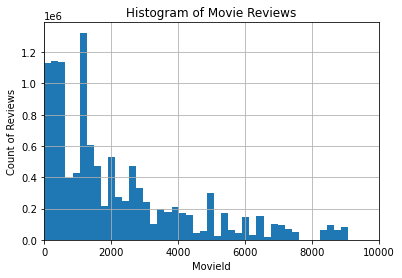

In [114]:
plt.hist(sample['movieId'].values, bins=len(sample['movieId'].value_counts()))

plt.xlabel('MovieId')
plt.ylabel('Count of Reviews')
plt.title('Histogram of Movie Reviews')
plt.xlim(0, 10000)
plt.grid(True)
plt.show()

In [115]:
final=pd.pivot_table(sample, values='adg_rating', index='userId', columns='movieId')
final

movieId,1,2,3,5,6,7,10,11,16,17,...,115713,116797,119145,122882,122886,122904,134130,134853,152081,164179
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.130435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.302591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.802591,0.302591,NaN,-0.197409,-0.697409,NaN,0.302591,0.302591,NaN,0.302591
4,-0.378099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.621901,NaN,1.121901,1.621901,-1.378099,0.121901,0.621901,NaN,1.121901,1.621901
5,0.247525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162538,-1.415584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584416,...,NaN,1.084416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
final_movie = final.fillna(final.mean(axis=0))
final_movie

movieId,1,2,3,5,6,7,10,11,16,17,...,115713,116797,119145,122882,122886,122904,134130,134853,152081,164179
userId,,,,,,,,,,,,,,,,,,,,,
1,0.260465,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,0.280523,0.364177,...,0.239156,0.213647,0.083603,0.149069,0.045616,0.106765,0.259378,0.194525,0.172771,0.296863
2,-0.130435,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,0.280523,0.364177,...,0.239156,0.213647,0.083603,0.149069,0.045616,0.106765,0.259378,0.194525,0.172771,0.296863
3,0.302591,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,0.280523,0.364177,...,0.802591,0.302591,0.083603,-0.197409,-0.697409,0.106765,0.302591,0.302591,0.172771,0.302591
4,-0.378099,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,0.280523,0.364177,...,1.621901,0.213647,1.121901,1.621901,-1.378099,0.121901,0.621901,0.194525,1.121901,1.621901
5,0.247525,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,0.280523,0.364177,...,0.239156,0.213647,0.083603,0.149069,0.045616,0.106765,0.259378,0.194525,0.172771,0.296863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162537,0.260465,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,0.280523,0.364177,...,0.239156,0.213647,0.083603,0.149069,0.045616,0.106765,0.259378,0.194525,0.172771,0.296863
162538,-1.415584,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,0.280523,0.584416,...,0.239156,1.084416,0.083603,0.149069,0.045616,0.106765,0.259378,0.194525,0.172771,0.296863
162539,0.260465,-0.278469,-0.360397,-0.441115,0.300946,-0.153864,-0.118043,0.102879,0.280523,0.364177,...,0.239156,0.213647,0.083603,0.149069,0.045616,0.106765,0.259378,0.194525,0.172771,0.296863


#### Criação do Modelo
        Como dito anteriormente foi escolhido clusterização como abordagem para a solução ultilizando, a princípio, o KMeans. Nesse modelo, primeiramente é escolhido o número de clusters que será dividido os usuários e, a partir dele, será gerado um modelo para identificar esses grupos.  
        Para escolher o número de clusters, foi utilizado o Método do Cotovelo. Esse método serve para encontrar o número ótimo de clusters*. 
        *Para esse dataset (por precisar de mais recursos que disponíveis), não será possivel gerar um número muito alto de clusters para utilizar esse método

--------------

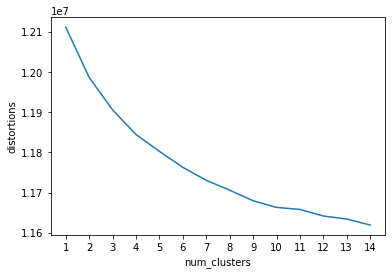

In [9]:
distortions = []
num_clusters =  range(1,15)


for n in num_clusters:
    print("-", end = '')
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(final_movie)
    distortions.append(kmeans.inertia_)
    
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

In [127]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(final_movie)
cluster_pred = kmeans.predict(final_movie)
cluster_pred

array([3, 8, 8, ..., 3, 3, 8])

In [128]:
unique_counts = collections.Counter(e for e in cluster_pred)
unique_counts

Counter({3: 83303,
         8: 9670,
         9: 7014,
         4: 11935,
         1: 2081,
         2: 6098,
         6: 7475,
         5: 27593,
         0: 5019,
         7: 2205})

<BarContainer object of 10 artists>

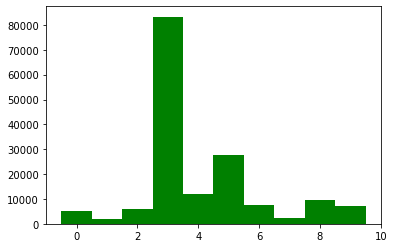

In [129]:
plt.bar(unique_counts.keys(), unique_counts.values(), 1)

#### Visualização do Modelo
        Como esse modelo possue muitas colunas fica difícil a visualização, desta forma foi utilizado um modelo Principal Component Análises para diminuir o dataset para apenas 2 colunas. 

In [130]:
x = final_movie.values
pca = PCA(n_components= 2, random_state=0)
pca.fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PCA1','PCA2'])
principalDf

,PCA1,PCA2
0,-0.032987,0.512990
1,1.925662,-0.352141
2,0.589138,1.353090
3,0.390423,1.158687
4,0.736515,-0.148875
...,...,...
162388,0.522256,-0.552528
162389,-0.928482,-0.494234
162390,-0.613429,-0.144223
162391,0.579702,-0.436964


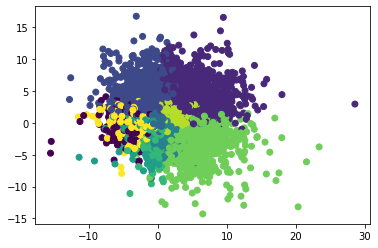

In [131]:
plt.scatter(principalDf['PCA1'], principalDf['PCA2'], c=cluster_pred)

In [204]:
def predict_cluster(model, user_reviews, tail_df, df_mean):
    Mean = user_reviews.groupby(by="userId",as_index=False)['rating'].mean()
    Rating_avg = pd.merge(user_reviews,Mean,on='userId')
    Rating_avg['adg_rating']=Rating_avg['rating_x']-Rating_avg['rating_y']
    user_pivoted = pd.pivot_table(Rating_avg, values='adg_rating', index='userId', columns='movieId')
    user_data = tail_df.append(user_pivoted, ignore_index=True)
    final_user_data = user_data.fillna(df_mean)
    cluster = model.predict(final_user_data)
    return cluster[1]

In [209]:
sample_test = sample.tail(50)
sample_test['rating'] = sample_test['rating_x']
sample_test = sample_test.drop(['rating_x','rating_y','adg_rating'], axis=1)
predict_cluster(kmeans, sample_test, final_movie.tail(1), final_movie.mean(axis=0))

8

In [261]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [304]:
def review_movies(movie_list):
    movies = movie_list
    reviews = pd.DataFrame([], columns=['userId', 'movieId', 'rating', 'timestamp'])
    for i in range(10):
        movie_index = random.randint(0, len(movies))
        rating = input('Nota Filme ' + movies.loc[[movie_index]]['title'].values[0] + ' ')
        
        if(rating == ''):
            rating = None
        else:
            rating = float(rating)
            
        user_array = [1, movies.loc[[movie_index]]['movieId'].values[0], rating, i ]
        user_df = pd.DataFrame([user_array], columns=['userId', 'movieId', 'rating', 'timestamp'])
        reviews = reviews.append(user_df, ignore_index=True)
        movies = movies.drop(movie_index).reset_index(drop=True)
    return reviews

In [306]:
top_25 = Rating_avg['movieId'].value_counts()[:25].index.tolist()

movie_list = movies[movies['movieId'].isin(top_25)].reset_index(drop=True)

user_review = review_movies(movie_list)

Nota Filme Pulp Fiction (1994) 5
Nota Filme Jurassic Park (1993) 2
Nota Filme Usual Suspects, The (1995) 5
Nota Filme Star Wars: Episode VI - Return of the Jedi (1983) 4
Nota Filme Fugitive, The (1993) 5
Nota Filme American Beauty (1999) 2
Nota Filme Star Wars: Episode IV - A New Hope (1977) 3
Nota Filme Godfather, The (1972) 4
Nota Filme Star Wars: Episode V - The Empire Strikes Back (1980) 2.7
Nota Filme Back to the Future (1985) 4.1


In [307]:
predict_cluster(kmeans, user_review, final_movie.tail(1), final_movie.mean(axis=0))

9